# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run scvi-sterescope](#scvi-sterescope)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_data/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/mouse_visium_snrna/'
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

In [3]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [4]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # for spatial mapping remove MT genes
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

Now let's look at QC: total number of counts and total number of genes per spot

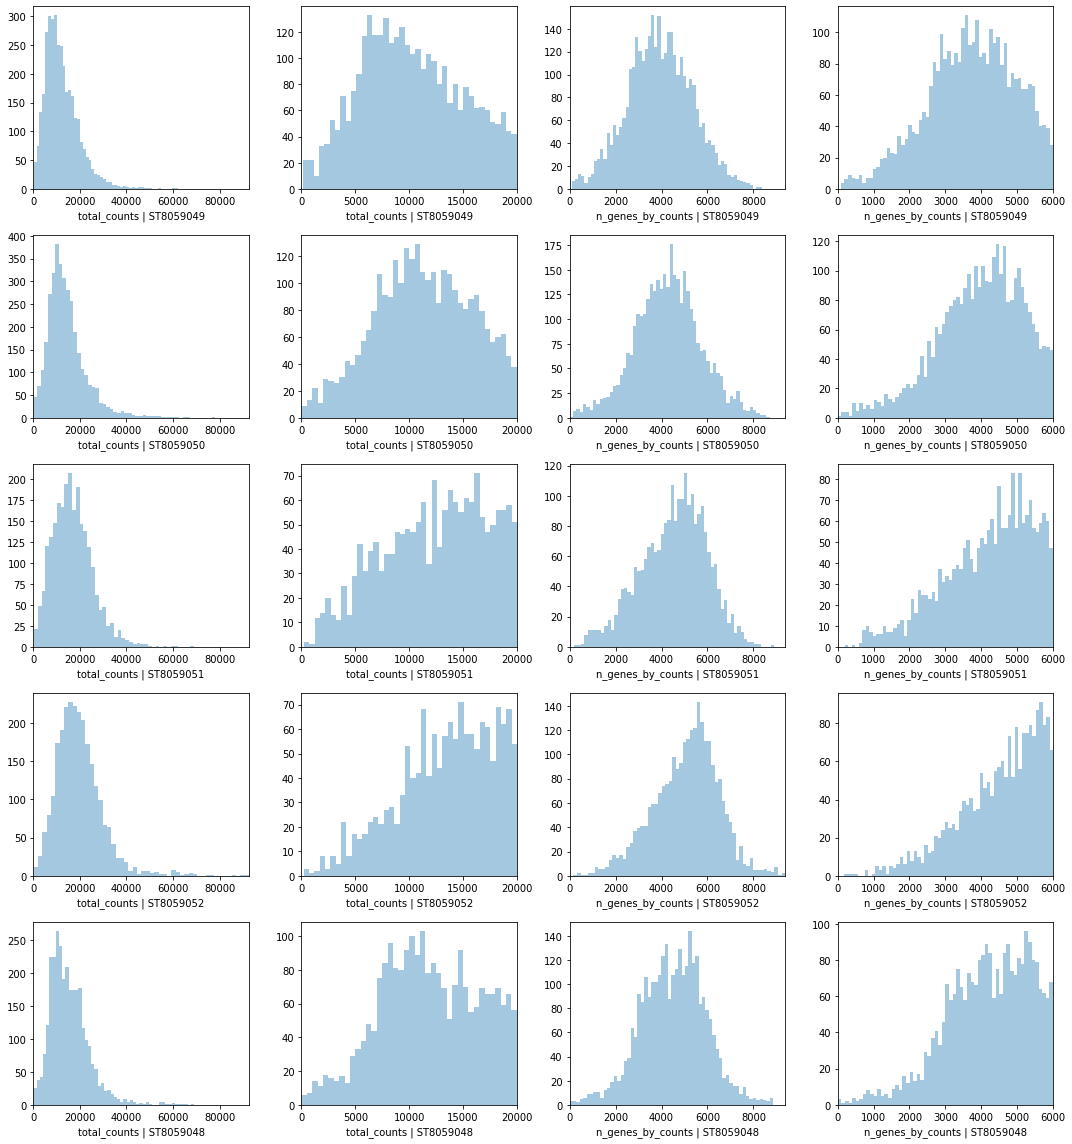

In [5]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


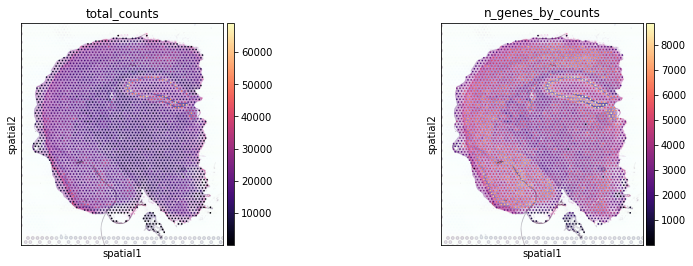

In [6]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


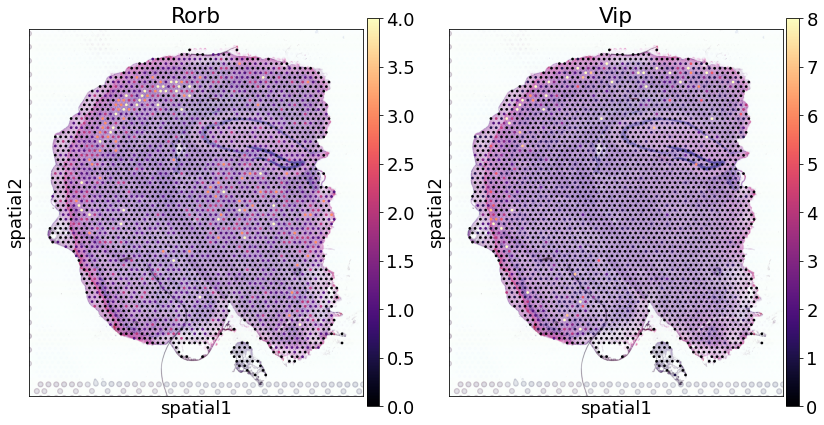

In [7]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :], 
              color=["Rorb", "Vip"], img_key='hires',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

In [8]:
adata.raw = adata

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [9]:
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{c2l_results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

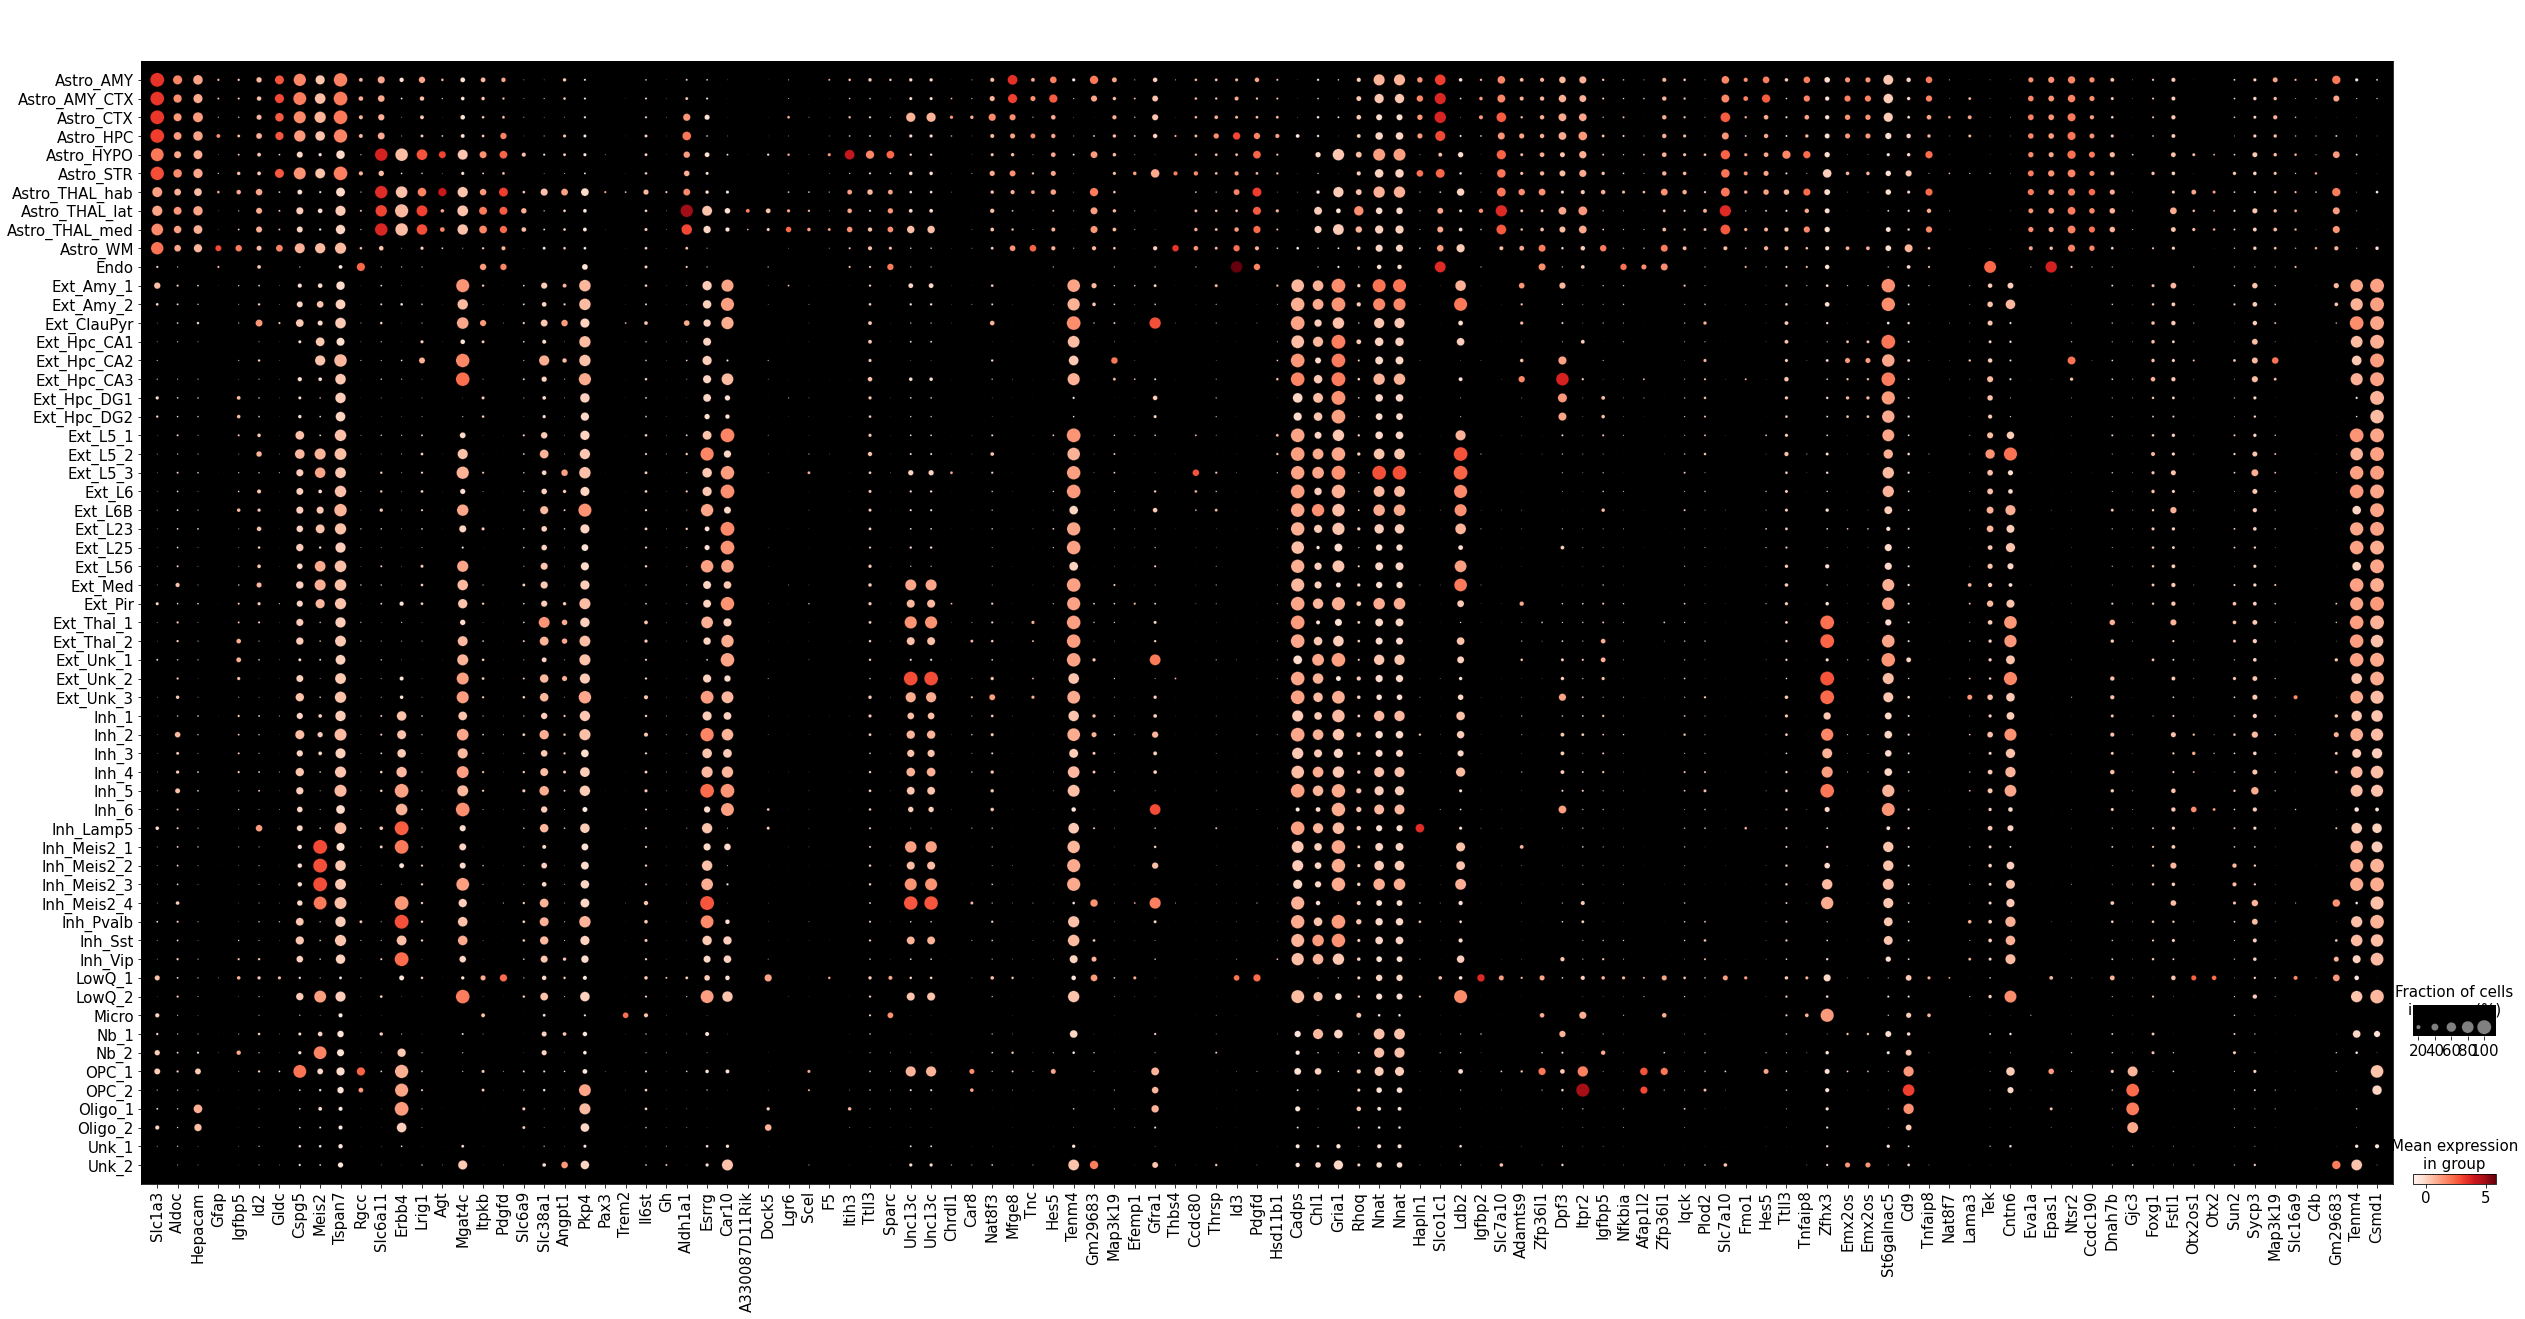

In [10]:
gene_list = pd.read_csv(f'{reg_path}figures/Subtype_markers.csv', header=0)['Genes']
with matplotlib.rc_context({'axes.facecolor':  'black'}):
    sc.pl.dotplot(adata_snrna_raw, gene_list, groupby='annotation_1', 
                  gene_symbols='SYMBOL', use_raw=False, 
                  show=True);

In [11]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_annotation_1_{i}' for i in adata_snrna_raw.obs['annotation_1'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_annotation_1_{i}', '', i) for i in adata_snrna_raw.obs['annotation_1'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [12]:
inf_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.006652,0.013381,0.009672,0.010551,0.016396,4.362995e-09,3.918688e-03,0.012995,0.020950,0.053045,...,6.475789,0.009182,2.363688,0.569750,2.202130,0.773202,2.177433,0.885846,1.399780,1.228170
ENSMUSG00000089699,0.001501,0.001095,0.002055,0.000696,0.003748,1.116136e-02,5.403521e-09,0.001581,0.001147,0.009992,...,1.259508,0.000859,0.512654,0.132410,0.383906,0.165249,0.423312,0.161883,0.227617,0.174571
ENSMUSG00000033845,0.114207,0.054338,0.085309,0.059021,0.066498,2.202430e-02,6.959011e-02,0.064746,0.104896,0.060093,...,0.214894,0.039218,0.108909,0.095944,0.084072,0.094551,0.077346,0.054940,0.041642,0.113457
ENSMUSG00000033813,0.088453,0.097077,0.129549,0.093324,0.080831,1.292675e-01,6.526587e-02,0.057145,0.082130,0.081030,...,0.194244,0.063650,0.084617,0.121712,0.108767,0.181124,0.140567,0.066971,0.013325,0.091371
ENSMUSG00000002459,3.596771,4.084791,4.167773,3.955367,1.140844,3.839240e+00,1.391272e+00,1.597041,1.308752,4.189671,...,0.062062,0.004818,0.133042,1.217572,0.614752,0.097037,0.037659,0.004848,0.107176,0.120861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064370,0.154425,0.135329,0.106853,0.123680,0.061573,8.559838e-02,2.359829e-01,0.087570,0.072310,0.312812,...,0.184294,0.044913,0.130184,0.070209,0.112571,0.116551,0.049836,0.060489,0.038373,0.070576
ENSMUSG00000051412,0.042569,0.033413,0.051312,0.052405,0.043928,5.851342e-02,5.412691e-09,0.033294,0.038056,0.069674,...,0.083921,0.012877,0.063890,0.057759,0.083447,0.102482,0.096118,0.067913,0.023124,0.097860
ENSMUSG00000079834,0.233599,0.240260,0.301797,0.227757,0.257566,4.087606e-01,1.732663e-01,0.321039,0.316733,0.072512,...,0.189396,0.059993,0.077447,0.020228,0.286553,0.304142,0.255407,0.111864,0.034153,0.088070


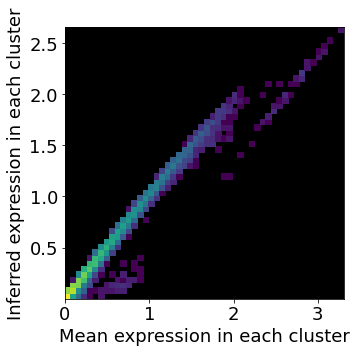

In [13]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

### Run scvi-sterescope <a class="anchor" id="scvi-sterescope"></a>

In [14]:
results_folder + 'scvi_stereoscope/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/mouse_visium_snrna/scvi_stereoscope/'

In [15]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import scStereoscope, stStereoscope
import scvi

rcParams['figure.figsize'] = 5, 5

In [16]:
adata_snrna_raw.X

array([[ 1.327872  ,  1.0640413 , -0.38277873, ...,  1.4373572 ,
         2.0676072 , -0.26928037],
       [-0.5701451 , -0.7450602 , -0.38277873, ..., -0.5192675 ,
        -0.8038919 , -0.26928037],
       [-0.5701451 , -0.7450602 , -0.38277873, ..., -0.5192675 ,
         0.30695567, -0.26928037],
       ...,
       [ 0.08279216, -0.7450602 , -0.38277873, ..., -0.5192675 ,
        -0.8038919 , -0.26928037],
       [-0.5701451 , -0.7450602 , -0.38277873, ..., -0.5192675 ,
        -0.8038919 , -0.26928037],
       [ 0.46473595,  1.0640413 , -0.38277873, ..., -0.5192675 ,
         0.30695567, -0.26928037]], dtype=float32)

In [17]:
adata_snrna_raw.layers["counts"] = adata_snrna_raw.raw.X.copy()

In [18]:
scvi.data.setup_anndata(adata_snrna_raw, layer = "counts", labels_key = "annotation_1")

adata_snrna_raw.obs["indices"] = np.arange(adata_snrna_raw.n_obs)
register_tensor_from_anndata(adata_snrna_raw, "ind_x", "obs", "indices")

model = scStereoscope(adata_snrna_raw)
model.train(lr = 0.01, n_epochs = 1000, frequency = 1)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["annotation_1"]                                         
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 40532 cells, 12819 genes, 1       
         batches, 59 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 1000 epochs                                                            
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  1741 s. / 1000 epochs                                               


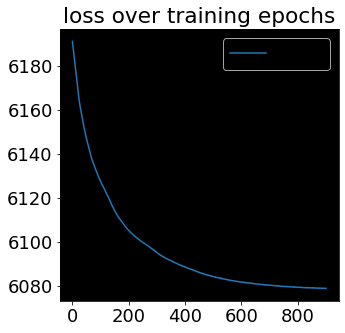

In [19]:
plt.plot(model.history["elbo_train_set"][100:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [20]:
params = model.get_params()
params[0].shape
model.save(f"{results_folder}scvi_stereoscope/scmodel_1k.pkl", overwrite = True)

- Filter genes to be the same as the scRNA-Seq data

In [26]:
adata_snrna_raw.var.index.isin(adata.var.index).sum(), adata_snrna_raw.shape

(12809, (40532, 12819))

In [28]:
#intersect = np.intersect1d(adata_snrna_raw.var_names, adata.var_names)
#adata = adata[:, intersect].copy()
inter_ind = adata_snrna_raw.var.index.isin(adata.var.index)
adata = adata[:, adata_snrna_raw.var_names[inter_ind]].copy()

#mask = [x in intersect for x in adata_snrna_raw.var_names]
params = [params[0][inter_ind, :], params[1][inter_ind]]

len(adata.var_names) == params[0].shape[0]

True

In [29]:
adata.layers["counts"] = adata.X.copy()
scvi.data.setup_anndata(adata, layer = "counts")

adata.obs["indices"] = np.arange(adata.n_obs)
register_tensor_from_anndata(adata, "ind_x", "obs", "indices")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14968 cells, 12809 genes, 1       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [30]:
spatial_model = stStereoscope(adata, params)
spatial_model.train(lr = 0.01, n_epochs = 20000, train_size = 1, frequency = 1)

INFO     Training for 20000 epochs                                                           
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  25525 s. / 20000 epochs                                             


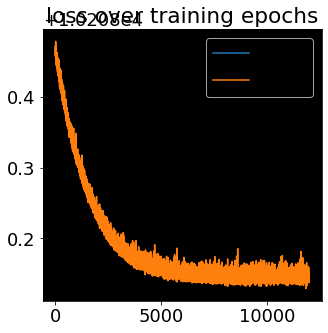

In [39]:
plt.plot(spatial_model.history["elbo_test_set"][8000:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][8000:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [32]:
adata_snrna_raw.var_names, adata.var_names

(Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000033845',
        'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
        'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000090031',
        'ENSMUSG00000033740',
        ...
        'ENSMUSG00000064357', 'ENSMUSG00000064358', 'ENSMUSG00000064360',
        'ENSMUSG00000065947', 'ENSMUSG00000064363', 'ENSMUSG00000064370',
        'ENSMUSG00000051412', 'ENSMUSG00000079834', 'ENSMUSG00000095041',
        'ENSMUSG00000063897'],
       dtype='object', name='ENSEMBL', length=12819),
 Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000033845',
        'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
        'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000090031',
        'ENSMUSG00000033740',
        ...
        'ENSMUSG00000024993', 'ENSMUSG00000063698', 'ENSMUSG00000024997',
        'ENSMUSG00000003228', 'ENSMUSG00000074733', 'ENSMUSG00000059326',
        'ENSMUSG0

In [33]:
import pandas as pd
adata.obsm["deconvolution"] = pd.DataFrame(data = spatial_model.get_proportions(), index = adata.obs.index, 
                                           columns = adata_snrna_raw.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"])


In [34]:
for ct in adata.obsm["deconvolution"].columns:
    adata.obs[ct] = adata.obsm["deconvolution"][ct]

In [35]:
adata.write(f"{results_folder}scvi_stereoscope/sp_20k.h5ad")

... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


Here we visualise locations of multiple cell types at once.

In [40]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

In [42]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Region clustering cell densities <a class="anchor" id="region_clustering"></a>

We find regions by clustering spots based on inferred molecule contributions of each cell type. We use leiden clustering that incorporates both the similarity of spots in cell locations and in their proximity, by including both when computing the KNN graph. Results are saved in `adata_vis.obs['leiden']`.

In [45]:
adata_vis = adata.copy()

sample_type = 'stereoscope'
adata_vis.obsm["stereoscope"] = adata_vis.obsm["deconvolution"].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 38)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.3)

In [46]:
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

Trying to set attribute `.uns` of view, copying.


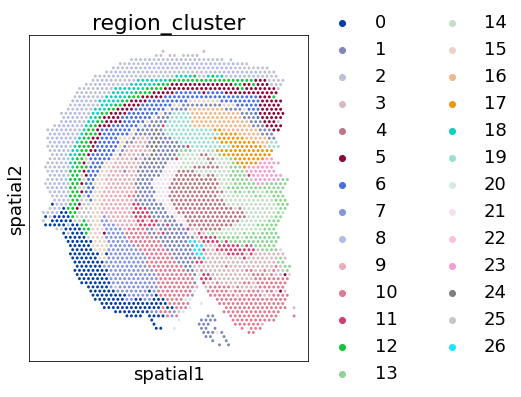

Trying to set attribute `.uns` of view, copying.


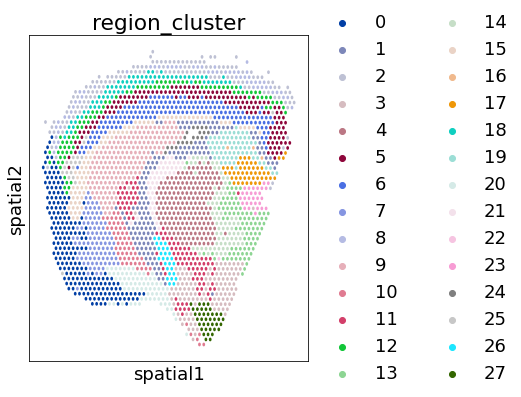

Trying to set attribute `.uns` of view, copying.


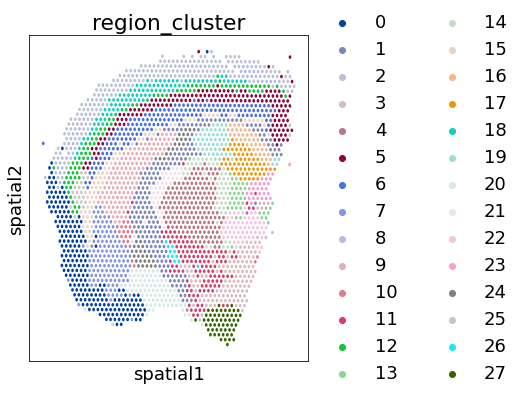

In [47]:
rcParams["figure.figsize"] = [5,6]
rcParams["axes.facecolor"] = "white"
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059048"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            );
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059051"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            )
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059052"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            )

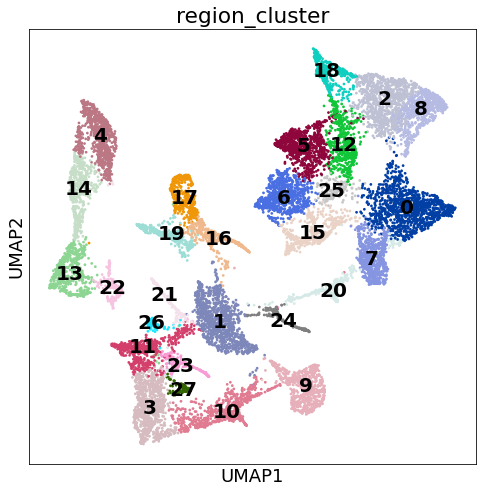

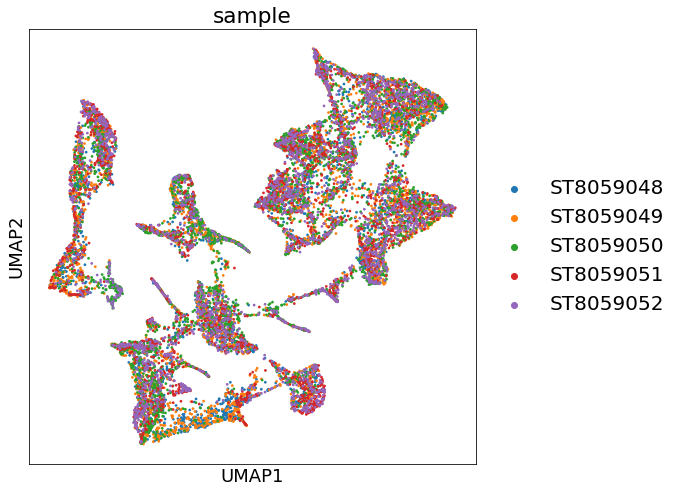

In [48]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

rcParams['figure.figsize'] = 8, 8
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=20)
sc.pl.umap(adata_vis, color=['sample'], size=30,
           color_map = 'RdPu', ncols = 2, #legend_loc='on data',
           legend_fontsize=20)

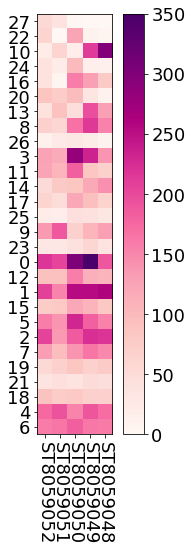

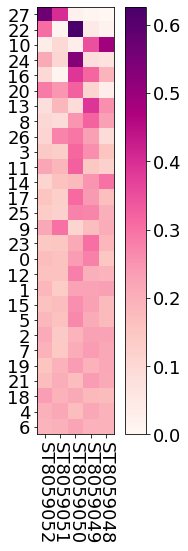

In [49]:
# check which clusters are in which section

def count_locations(adata, sample, cluster):
    
    return (adata.obs['sample'].isin([sample]) & adata.obs['region_cluster'].isin([cluster])).sum()
    
count_mat = [[count_locations(adata_vis, i, j) 
              for i in adata_vis.obs['sample'].unique()]
             for j in adata_vis.obs['region_cluster'].unique()]
count_df = pd.DataFrame(count_mat, index=adata_vis.obs['region_cluster'].unique(), 
                        columns=adata_vis.obs['sample'].unique())
count_fraq_df = (count_df.T / count_df.sum(1)).T

from scipy.stats import entropy
count_ent = entropy(count_fraq_df, base=2, axis=1)
count_df = count_df.iloc[np.argsort(count_ent),:]
count_fraq_df = count_fraq_df.iloc[np.argsort(count_ent),:]

from cell2location.plt.plot_heatmap import clustermap
clustermap(count_df, figure_size=[4, 8], cluster_rows=False, cluster_cols=False)
clustermap(count_fraq_df, figure_size=[4, 8], cluster_rows=False, cluster_cols=False)

Save resulting adata with clustering and diffusion maps

In [51]:
adata_file = results_folder \
                +'scvi_stereoscope'+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)

In [123]:
adata_file

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

Modules and their versions used for this analysis

In [55]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.4
numpy.core 1.19.4
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.4
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.3
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
n